In [1]:
import numpy as np

from base64 import b64encode
import PIL
import io

from google.colab import drive

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import argparse
import time
from pathlib import Path

from google.colab.patches import cv2_imshow
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import os

dir_base = "/content/drive/MyDrive/Master/Computación inteligente/Prácticas/YOLO/"
# dir_base = "/content/drive/MyDrive/Master/"

En este notebook se va a desarrollar un detector de gestos utilizando el algoritimo YOLO ("You Only Look Once"). Este sistema utiliza una red neuronal artificial que divide una imagen en regiones para determinar la probabilidad de que una de ellas sea un objeto en concreto.

Vamos a ver el procedimiento para hacer funcionar este método.

# Configuración inicial

En primer lugar vamos a realizar la configuración del notebook


## Drive

Permitimos el acceso del notebook a google drive, donde podrá acceder a algunos recuersos (como por ejemplo los pesos de la red).

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Instalación de dependencias

Esta versión usa el [repositorio YOLOv7](https://github.com/WongKinYiu/yolov7) de WongKinYiu. 

Para utilizarlo vamos a descargarlo:

In [3]:
# Download YOLOv7 repository and install requirements
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Descargar de los datos

Para realizar estas pruebas, vamos a utilizar la plataforma Roboflow, la cual nos ofrece una gran cantidad de distintos conjuntos de datos formateado para nuestras necesidades. En el caso de la red YOLO, además de las imagenes, se requiere un fichero que indique las distintas regiones de una imagen donde hay un elemento y que elemento es.

In [4]:
# Install roboflow in python
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="PPj9HIcwWLRNI1Y9JFUh")
project = rf.workspace("ktnf749-snu-ac-kr").project("sign-hb57g")
dataset = project.version(1).download("yolov7")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Sign-1 in yolov7pytorch:: 100%|██████████| 8058/8058 [00:03<00:00, 2137.33it/s]


Ahora vamos a mostrar algunas de las imagenes para ver como esta construido el dataset:

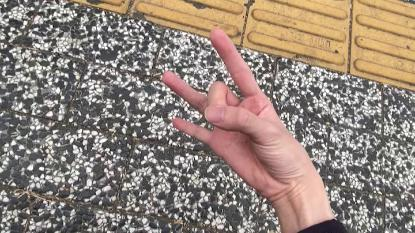

Label: 8





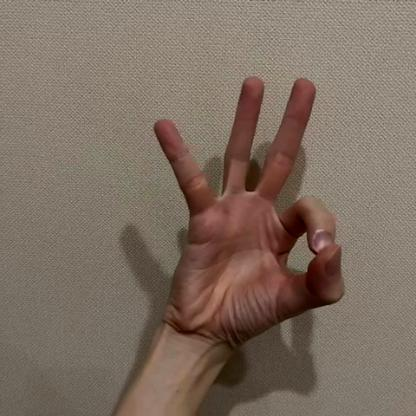

Label: 9





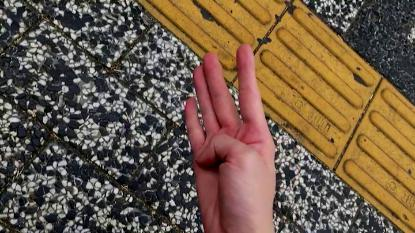

Label: 4





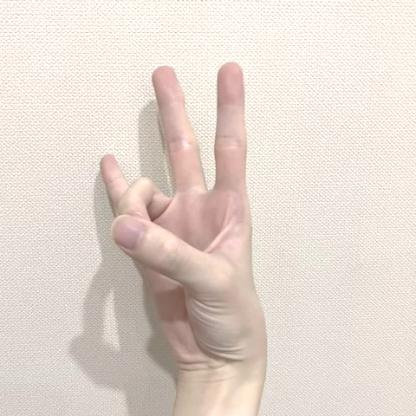

Label: 7





In [5]:
images_dir = "/content/yolov7/Sign-1/train/images"
labels_dir = "/content/yolov7/Sign-1/train/labels"

for img_name in os.listdir(images_dir)[:4]:
  cv2_imshow(cv2.imread(images_dir + "/" +img_name))
  l = open(labels_dir + "/" + img_name[:-4]+".txt", "r").read();

  l = int(l.split(" ")[0])
  if l==0:
    l=1
  elif l==1:
    l=10
  print("Label:",l)
  print("\n\n")

# Entrenamiento inicial

En el caso de que queramos entrenar nuestra red se pude descomentar el código que se encuentra en la siguiente celda. 

En este caso, se realizaría un entrenamiento con un tamaño de batch de 16, 100 epocas, con los pesos del directorio base y los datos descargados anteriormente (con toda la información en el .yaml).

In [ ]:
# run this cell to begin training
%cd /content/yolov7

# !python train.py --batch 16 --epochs 100 --data {dataset.location}/data.yaml --weight "/content/drive/MyDrive/Master/Computación inteligente/Prácticas/YOLO/best.pt" --device 0

/content/yolov7
YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='/content/yolov7/yolov7/Sign-1/data.yaml', device='0', entity=None, epochs=100, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp6', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='/content/drive/MyDrive/Master/Computación inteligente/Prácticas/YOLO/best.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, mom

# Código auxiliar

Antes de continuar, vamos a definir una serie de funciones para visualizar el correcto funcionamiento de nuestra red.

## Acceso a la cámara para sacar una imagen

Utilizamos código javascript para poder acceder a la cámara desde el colab. Esta función mostrará la cámara, sacará una foto cuando se pulse un botón y la guardará en la dirección que se indique.

In [6]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  print(filename)
  return filename

## Acceso a la cámara para sacar un vídeo

En este caso, al igual que el código anterior se accede a la cámara, pero sin necesidad de sacar fotos para poder acceder a la información de las imagenes.

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: true});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Modificación del predict.py

Vamos a realizar algunas modificaciones al fichero predict. Estas modificaciones van orientadas a eliminar algunas características innecesarias y añadir la posibilidad de realizar una predicción utilizando la cámara de vídeo en lugar de recolectar los datos de una imagen de un fichero.

In [8]:
%cd /content/yolov7

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def init_detect(save_img=False, classes=None, agnostic_nms=True, iou_thres=0.45, conf_thres=0.25, save_conf=True, device='', exist_ok=False, 
            name="exp",project='runs/detect', weights='yolov7.pt',view_img=True, save_txt=False, imgsz=640, nosave=False):
      # Initialize
    device = select_device(device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if half:
        model.half()  # to FP16

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once

    return model, imgsz, stride, device, half, conf_thres, iou_thres, classes, agnostic_nms, names

[model, imgsz, stride, device, half, conf_thres, iou_thres, classes, agnostic_nms, names] = init_detect(weights=dir_base+"best.pt", conf_thres=0.45)

def detect(model, source_image = None):
    result = []

    im0s = source_image
    img = letterbox(im0s, imgsz, stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
        
    # Start prediction
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)

    # Process detections
    for _, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0s size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()

            # Get rectangles
            for *xyxy, conf, cls in reversed(det):
                label = f'{names[int(cls)]} {conf:.2f}'
                c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
                result.append([label,c1, c2])

    return result

/content/yolov7
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)


Una vez definida cambiada la manera de hacer predicciones, vamos a crear un grupo de funciones donde utilicemos el predict y lo visualicemos.

In [9]:
def getColor(c):
  if (c==1): return (255,0,0)
  elif (c==2): return (89,60,0)
  elif (c==3): return (16,64,41)
  elif (c==4): return (0,7,51)
  elif (c==5): return (255,64,166)
  elif (c==6): return (0,255,0)
  elif (c==7): return (0,0,255)
  elif (c==8): return (60,0,89)
  elif (c==9): return (0,60,89)
  elif (c==10): return (156,0,90)

# Get an array two corners, color and probability of the rectagles
def modificationToImage(img):
  b = False
  x = detect(model, source_image=img)
  res = []
  for xi in x:
    color, prob = xi[0].split(' ')
    res.append([xi[1][0], xi[1][1], xi[2][0], xi[2][1], int(color), float(prob)])
  return res# [[100,30,400,600]]#img

def get_prediction(file):
  i = cv2.imread(file)
  image = i

  for r in modificationToImage(i):

    start_point = (r[0], r[1])
      
    # Ending coordinate, here (220, 220)
    # represents the bottom right corner of rectangle
    end_point = (r[2], r[3])

    c = r[4]
    prob = r[5]

    # Blue color in BGR

    color = getColor(c)
      
    # Line thickness of 2 px
    thickness = 2

    image = cv2.rectangle(image, start_point, end_point, color, thickness)

    # Label
    text = str(c)+ ": "+ str(prob)

    image = cv2.putText(image, text, (r[0], max(r[1]-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,0,0), 6)
    # put smaller white text over black text
    image = cv2.putText(image, text, (r[0], max(r[1]-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

  # Displaying the image 
  cv2_imshow(image)

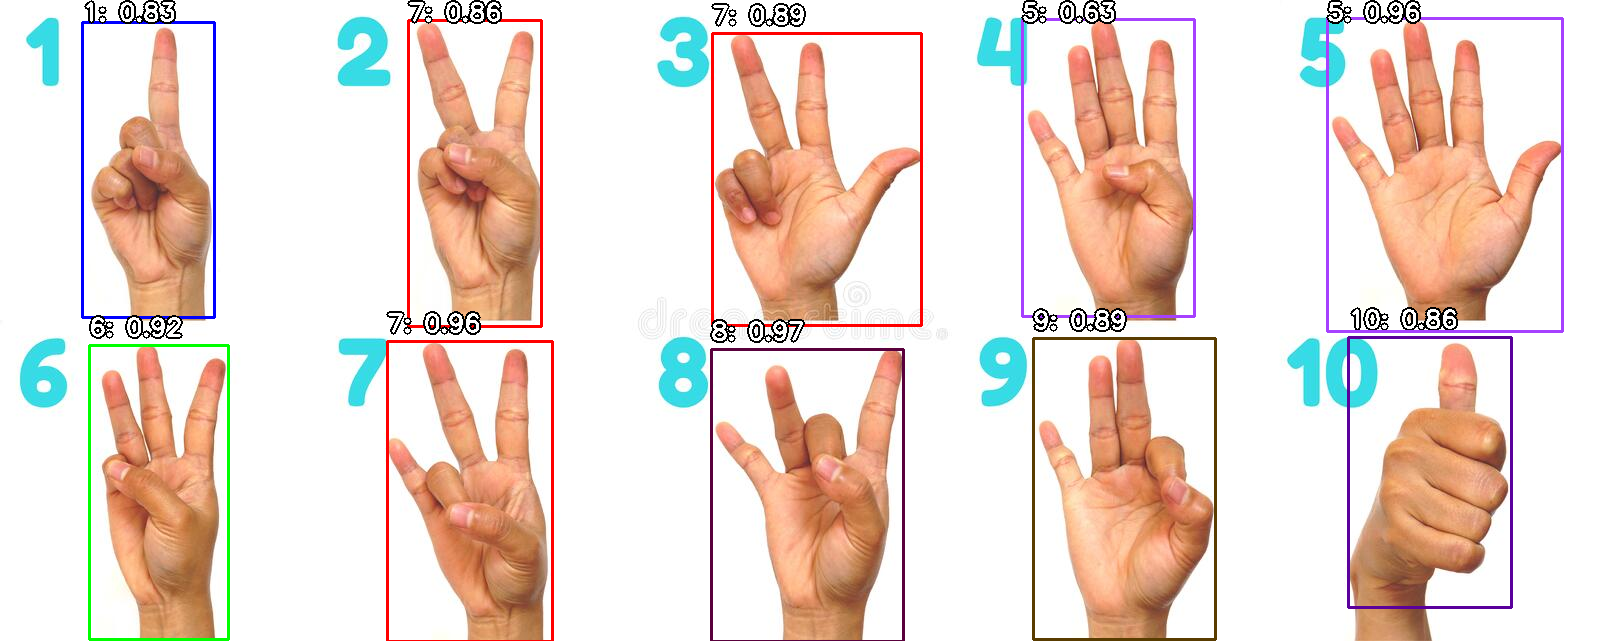

In [10]:
get_prediction(dir_base+"manos.jpg")

# Utilización de la red con una imagen

Utilizando la función vista anteriormente se puede acceder a la cámara, sacar una foto y guardarla. Una vez guardada, se puede utilizar la función get_prediction identificar distintos elementos en una misma imagen:

/content


<IPython.core.display.Javascript object>

photo.jpg
Saved to photo.jpg


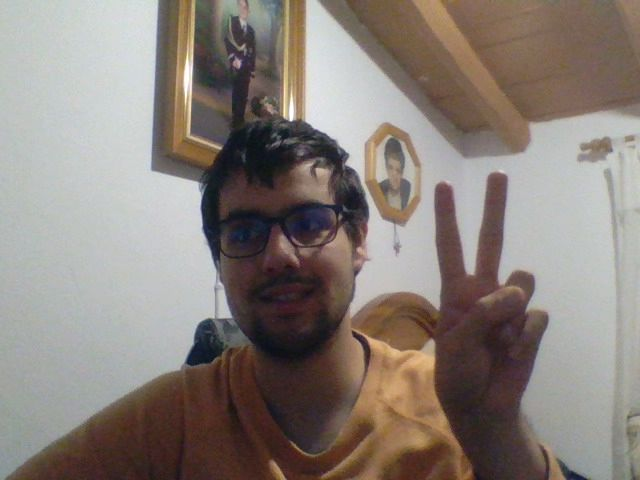

/content/yolov7


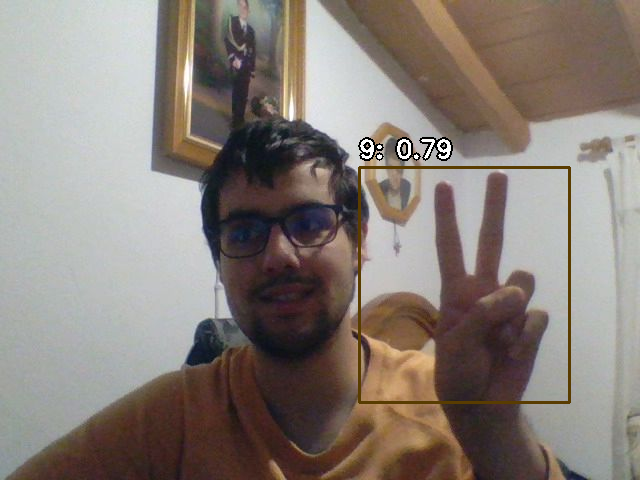

In [ ]:
%cd /content

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  print(str(err))


%cd /content/yolov7
get_prediction("/content/photo.jpg")

# Utilización de la red con un vídeo

Al igual que en el caso anterior, usamos el código para activar la cámara y trabajar con la imagen en tiempo real:

In [11]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

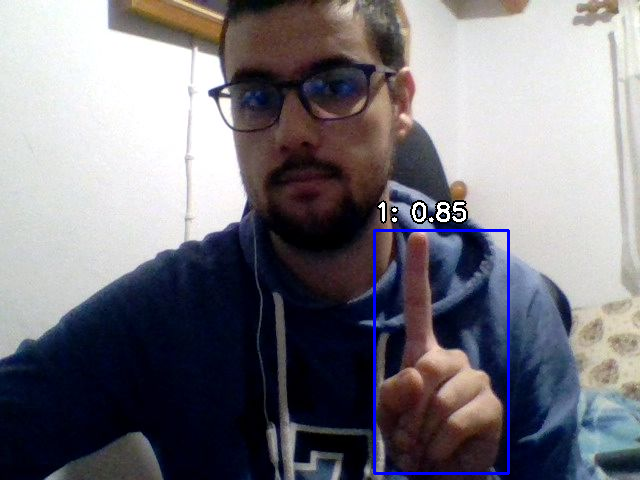

In [12]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

lastImage = None
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img2 = js_to_image(js_reply["img"])
    lastImage= img2


    bbox_array = np.zeros([img2.shape[0],img2.shape[1],4], dtype=np.uint8)

    # get rectangle region coordinates
    faces = modificationToImage(img2)
    
    # get face bounding box for overlay
    for (x,y,w,h,c,prob) in faces:
      color = getColor(c)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(w,h),color,2)
      
      text = str(c)+ ": "+ str(prob)
      bbox_array = cv2.putText(bbox_array, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,0,0), 6)
      # put smaller white text over black text
      bbox_array = cv2.putText(bbox_array, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes     

## Print Last image
faces = modificationToImage(lastImage)

# get face bounding box for overlay
for (x,y,w,h,c,prob) in faces:
  color = getColor(c)
  lastImage = cv2.rectangle(lastImage,(x,y),(w,h),color,2)
  
  text = str(c)+ ": "+ str(prob)
  lastImage = cv2.putText(lastImage, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,0,0), 6)
  # put smaller white text over black text
  lastImage = cv2.putText(lastImage, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

cv2_imshow(lastImage)

# https://colab.research.google.com/drive/1cY3oQtVsSO1b0yuR8X_6HX6Z2f-k4TBW#scrollTo=1nkSnkbkk4cC

# Comprobación de resultados

Vamos a ver como clasifica la red las imagenes con las que se ha entrenado:

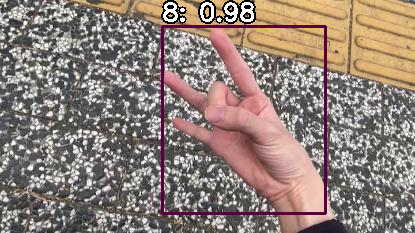

Label: 8





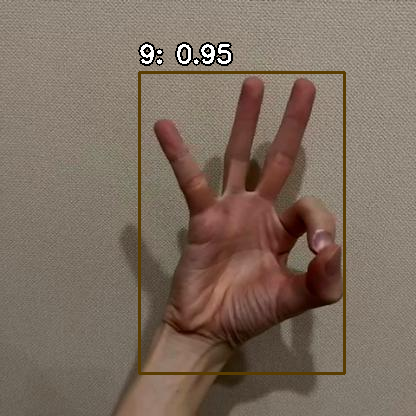

Label: 9





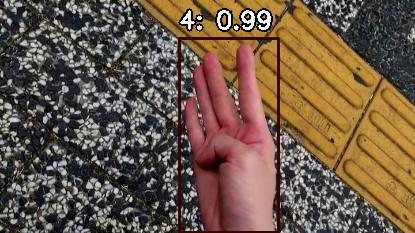

Label: 4





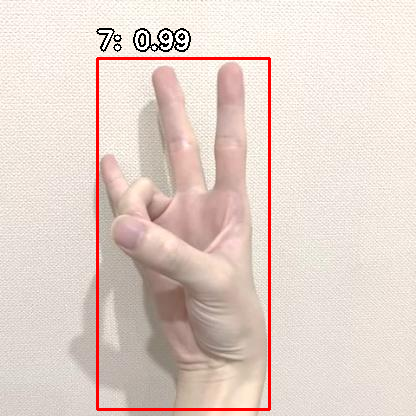

Label: 7





In [13]:
images_dir = "/content/yolov7/Sign-1/train/images"
labels_dir = "/content/yolov7/Sign-1/train/labels"

for img_name in os.listdir(images_dir)[:4]:
  get_prediction(images_dir + "/" +img_name)
  l = open(labels_dir + "/" + img_name[:-4]+".txt", "r").read();

  l = int(l.split(" ")[0])
  if l==0:
    l=1
  elif l==1:
    l=10
  print("Label:",l)
  print("\n\n")

Vamos a realizar las mismas pruebas pero con el conjunto de test:

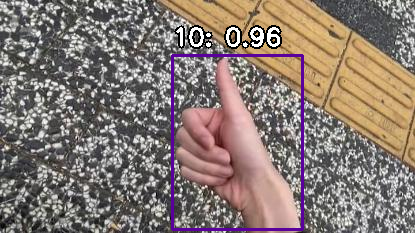

Label: 10





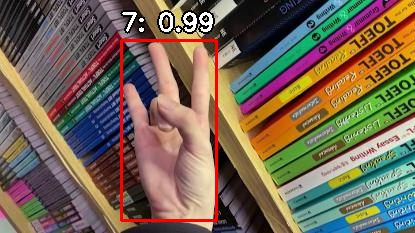

Label: 7





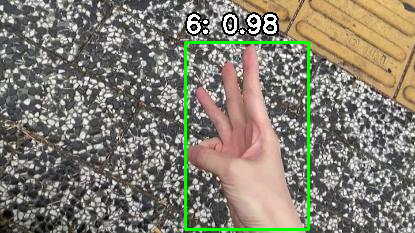

Label: 6





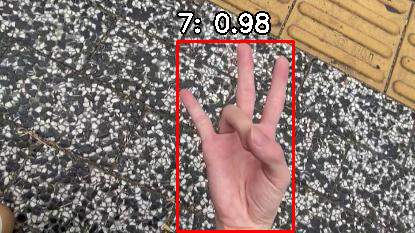

Label: 7





In [14]:
images_dir = "/content/yolov7/Sign-1/test/images"
labels_dir = "/content/yolov7/Sign-1/test/labels"

for img_name in os.listdir(images_dir)[:4]:
  get_prediction(images_dir + "/" +img_name)
  l = open(labels_dir + "/" + img_name[:-4]+".txt", "r").read();

  l = int(l.split(" ")[0])
  if l==0:
    l=1
  elif l==1:
    l=10
  print("Label:",l)
  print("\n\n")

Por último, vamos a repetir el procedimiento para el conjunto de validación:

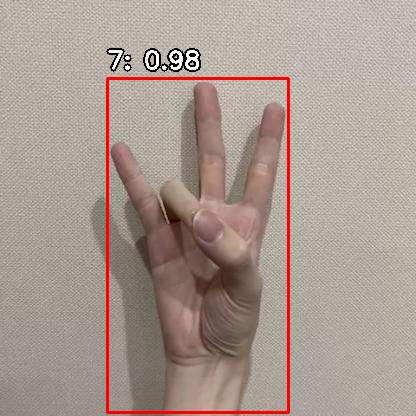

Label: 7





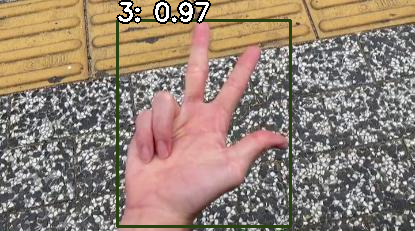

Label: 3





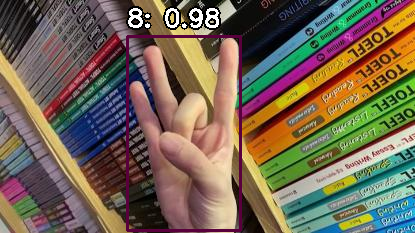

Label: 8





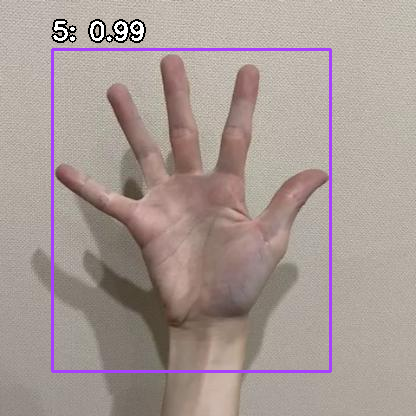

Label: 5





In [15]:
images_dir = "/content/yolov7/Sign-1/valid/images"
labels_dir = "/content/yolov7/Sign-1/valid/labels"

for img_name in os.listdir(images_dir)[:4]:
  get_prediction(images_dir + "/" +img_name)
  l = open(labels_dir + "/" + img_name[:-4]+".txt", "r").read();

  l = int(l.split(" ")[0])
  if l==0:
    l=1
  elif l==1:
    l=10
  print("Label:",l)
  print("\n\n")

Vemos que para el conjunto de entrenamiento se obtienen buenos datos, sin embargo, si se usan las manos de otras personas estos resultados no son tan buenos. Por esta razón, vamos a realizar un reentrenamiento con mis imagenes de mis propias manos.

Antes de realizar este proceso, se ha grabado un vídeo que vamos a pasar por la red, de esta manera se pueden comparar los resultados antes del reentrenamiento y después:

In [51]:
def check_video(input_file, output_file):
  def modify_image(frame):
      # Modificar la imagen aquí
      # return frame
      ret = frame
      faces = modificationToImage(ret)
      # get face bounding box for overlay
      for (x,y,w,h,c,prob) in faces:
        color = getColor(c)
        ret = cv2.rectangle(ret,(x,y),(w,h),color,2)
        
        text = str(c)+ ": "+ str(prob)
        ret = cv2.putText(ret, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,0,0), 6)
        # put smaller white text over black text
        ret = cv2.putText(ret, text, (x, max(y-10,0+20)), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

      # print(frame.shape)
      return ret

  # Abrir video
  cap = cv2.VideoCapture(input_file)

  # Obtener las dimensiones del video
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))

  # Configurar el video de salida
  fourcc = cv2.VideoWriter_fourcc(*"mp4v")
  out = cv2.VideoWriter(output_file, fourcc, 30.0, (frame_width, frame_height), True)

  c = 0
  # Leer y modificar cada frame del video
  while True:
      ret, frame = cap.read()
      if not ret:
          break
      c=c+1
      frame = modify_image(frame)
      out.write(frame)
  # Liberar los recursos y cerrar el video
  cap.release()
  out.release()

In [53]:
check_video(dir_base+"video_test.mp4", dir_base+"output_base_img.mp4")

# Entrenamiento con mis propias manos

Para realizar esta parte, primero vamos a descargar los datos de roboflow con el dataset

In [54]:
# Install roboflow in python
!pip install roboflow

from roboflow import Roboflow

rf_new = Roboflow(api_key="PPj9HIcwWLRNI1Y9JFUh")
project_new = rf_new.workspace("prueba-hvfpq").project("hands-mx9de")
dataset_new = project_new.version(3).download("yolov7")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Hands-3 in yolov7pytorch:: 100%|██████████| 532/532 [00:00<00:00, 1891.04it/s]


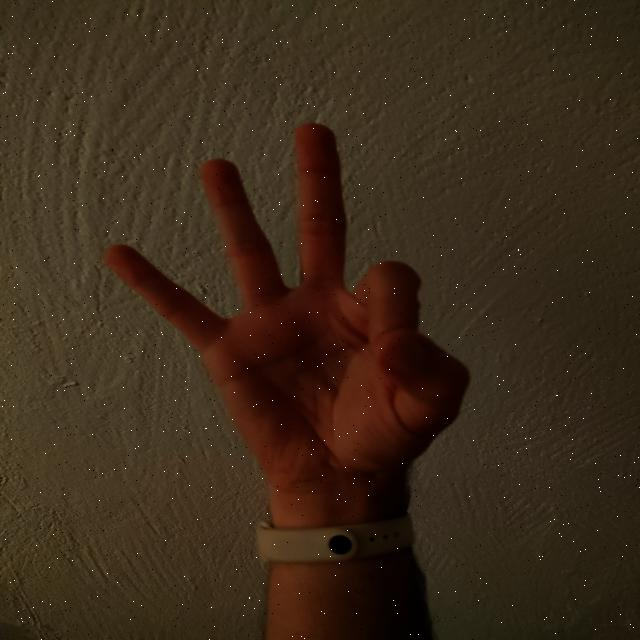

Label: 9





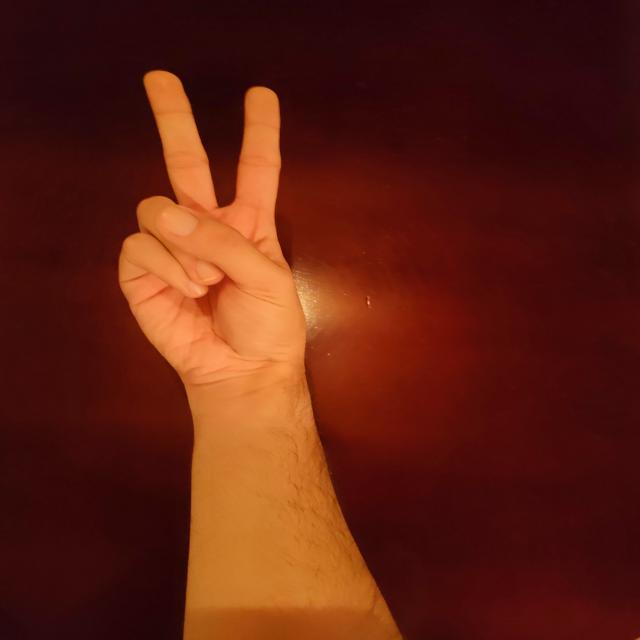

Label: 2





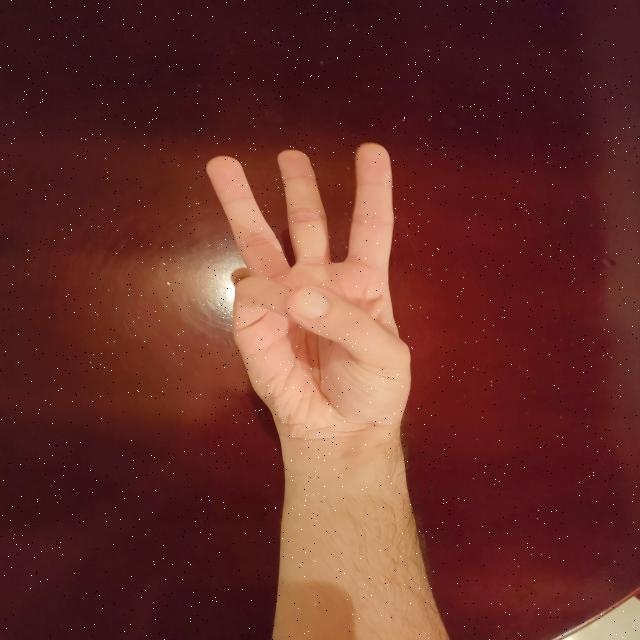

Label: 6





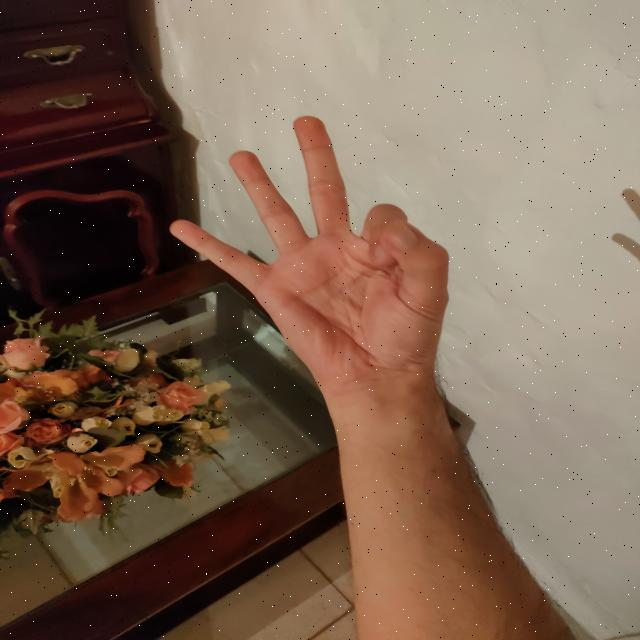

Label: 9





In [55]:
# Ejemplos:
images_dir = "/content/yolov7/Hands-3/train/images"
labels_dir = "/content/yolov7/Hands-3/train/labels"

for img_name in os.listdir(images_dir)[:4]:
  cv2_imshow(cv2.imread(images_dir + "/" +img_name))
  l = open(labels_dir + "/" + img_name[:-4]+".txt", "r").read();

  l = int(l.split(" ")[0])
  if l==0:
    l=1
  elif l==1:
    l=10
  print("Label:",l)
  print("\n\n")

In [56]:
# Copiamos nuestras imagenes en la del dataset anterior para entrenar con todas las imagenes

images_dir = "/content/yolov7/Hands-3/train/images"
labels_dir = "/content/yolov7/Hands-3/train/labels"

!ls "/content/yolov7/Sign-1/train/images" | wc -l 
!ls "/content/yolov7/Sign-1/train/labels" | wc -l 

!cp -r "/content/yolov7/Hands-3/train/images/" "/content/yolov7/Sign-1/train/"
!cp -r "/content/yolov7/Hands-3/train/labels/" "/content/yolov7/Sign-1/train/"

!ls "/content/yolov7/Sign-1/train/images" | wc -l 
!ls "/content/yolov7/Sign-1/train/labels" | wc -l 

3714
3714
3954
3954


Volvemos a entrenar nuestro modelo, pero en esta ocasión solo usamos los datos nuevos:

In [57]:
%cd /content/yolov7

# !python train.py --batch 16 --epochs 20 --data {dataset.location}/data.yaml --weight "/content/drive/MyDrive/Master/Computación inteligente/Prácticas/YOLO/best.pt" --device 0

/content/yolov7


# Prueba del modelo

En primer lugar vamos a cargar los pesos del entrenamiento. En este caso el fichero se llama best_myHands.pt:

In [59]:
[model, imgsz, stride, device, half, conf_thres, iou_thres, classes, agnostic_nms, names] = init_detect(weights=dir_base+"best_myHands.pt", conf_thres=0.45)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


Ahora vamos a utilizar la función predict con la imagen de todas las manos, como se hizo para el primer modelo:

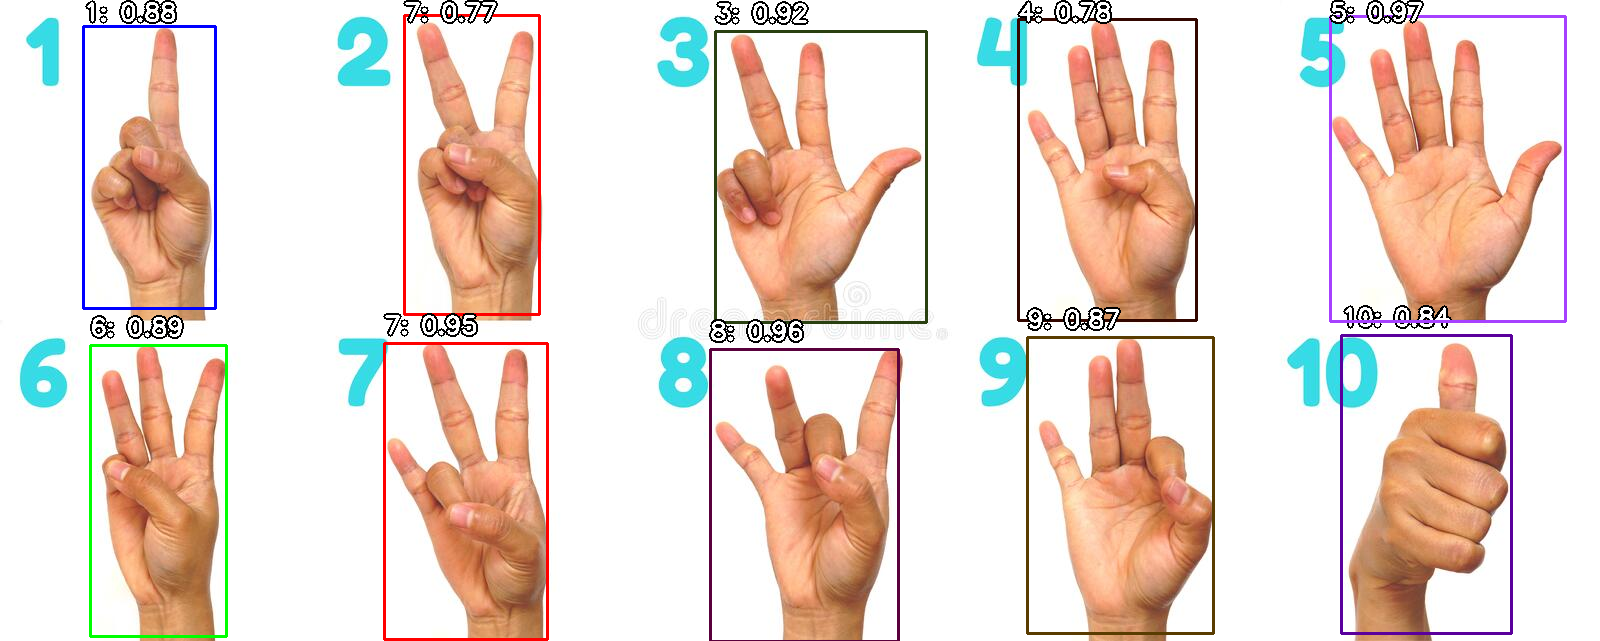

In [60]:
get_prediction(dir_base+"manos.jpg")

Podemos observar una mejora en la precisión de reconocimiento de las manos en todos los dígitos, excepto en el número 2, que todavía tiene problemas para ser diferenciado del número 7. Aunque es comprensible debido a la similitud en la forma de ambos números.

Ahora vamos a pasar por la red el mismo vídeo que anteriormente se pasó. De esta manera podremos comparar los resultados de una mejor manera:

In [61]:
check_video(dir_base+"video_test.mp4", dir_base+"output_myHands.mp4")

La comparación de ambos vídeos no muestra que el resultado es mucho mejor ahora que antes (no predice tantos falsos signos y hace más predicciones correctas). En el readme se pueden encontrar una comparación de los dos vídeos.